Drexel University CS613 Final Project
<br>
Music Genre Classification Analysis using Mel-Frequency Cepstral Coefficients as Features
<br>
Jack Anderson
<br>
June 8th, 2024

-- --

### Import necessary libraries

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import librosa
import pandas as pd
import seaborn as sns

from tensorflow import keras
from keras import Sequential, Input, layers, optimizers
from keras.layers import Flatten, Dense, BatchNormalization
from keras.optimizers import Adam

### Utility Functions


In [5]:
# generic function to calculate the list of mfcc's of a given wav file to use throughout the project
# n_mfcc is the number of mfccs to sample for the wav file
def calculate_mfcc(wav_file, n_mfcc):
    # use librosa to load the wav file, y is an audio time series and sr is the sampling rate of y
    y, sr = librosa.load(wav_file)

    # extract mfcc's from the data
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    return mfccs

# calculate the mean of an input mfcc array over the length of the data set
def mean_mfcc(mfccs):
    return np.mean(mfccs, axis=1)

# function to load the wav data with differing numbers of mfcc's
def load_mfcc_data(n_mfcc=20):
    # dir that holds the different directories of genre specific .wav's
    base_dir = 'Data/genres_original'

    # lists to hold mfccs and genre labels
    mfccs_list = []
    labels_list = []

    # loop over each genre directory
    for genre in os.listdir(base_dir):
        genre_dir = os.path.join(base_dir, genre)

        # loop over each file in the genre directory
        for file_name in os.listdir(genre_dir):

            # error handling to ensure the file is in fact a .wav
            if file_name.endswith('.wav'):
                wav_file_path = os.path.join(genre_dir, file_name)

                # calculate the mfcc of the specified wav file
                mfccs = calculate_mfcc(wav_file_path, n_mfcc)

                # simplify the 
                mean_mfccs = mean_mfcc(mfccs)

                mfccs_list.append(mean_mfccs)

                labels_list.append(genre)
    return mfccs_list, labels_list

# function to load mfcc data from the csv file
def load_mfcc_data_csv(n_mfcc=20):
    base_dir = 'Data/csvs'
    # Read the CSV file into a DataFrame
    data = pd.read_csv(f'{base_dir}/mfccs.csv')
    
    # Extract the MFCC columns (all columns except the last one, which is 'Label')
    mfccs_list = data.iloc[:, 0:n_mfcc].values.tolist()  # Convert to list of lists
    
    # Extract the labels column (last column, named 'Label')
    labels_list = data['Label'].tolist()
    
    return mfccs_list, labels_list

# writes the mfcc data to a csv file for ease of access
def write_mfcc_data(mfccs_list, labels_list, n_mfcc):
    base_dir = 'Data/csvs'
    # Ensure the output directory exists
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    
    # Create a DataFrame from the MFCCs and labels
    data = pd.DataFrame(mfccs_list, columns=[f'MFCC_{i+1}' for i in range(n_mfcc)])
    data['Label'] = labels_list
    
    # Construct the CSV filename based on the number of MFCCs
    csv_filename = os.path.join(base_dir, f'mfccs.csv')
    
    # Write the DataFrame to a CSV file
    data.to_csv(csv_filename, index=False)
    
    print(f"Data saved to {csv_filename}")

# given the original y, the y prediction and test, and the test indices pertaining to the original y, return the mismatched predictions filenames
def return_mismatched_files(y, y_pred, y_test, idx_test):
    genre = np.array(["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"])
    mismatched_idx = idx_test[y_test != y_pred]
    incorrect_preds = y_pred[y_test != y_pred]
    # takes advantage of the nice naming convention of the wav files and the fact there are 100 of each... would need reworked for larger datasets
    files = [f"{y[idx]}.{idx % 100} misclassed as {genre[incorrect_preds[i]]}" for i, idx in enumerate(mismatched_idx)]
    return files

# generate a matplotlib/seaborn confusion matrix.  pass in the confusion matrix, the title for the output, and the color scheme
def confusion_matrix_plot(matrix, title, color="Blues"):
    genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap=color, xticklabels=genres, yticklabels=genres)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    return plt

In [6]:
# # Generate the mfccs and labels for the entire dataset, then load it to a csv for ease of access.  Commented to speed up re-running the entire Notebook
# mfccs_list, labels_list = load_mfcc_data(128)
# write_mfcc_data(mfccs_list, labels_list, 128)

## Logistic Regression

In [7]:
def mfcc_logistic_regression(X_train, y_train):
    # train the multi-class logistic regression model
    model = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=1000)
    model.fit(X_train, y_train)

    # return the multi-class logistic regression model
    return model

def train_logistic_regression(n_mfccs=20):
    mfccs_list, labels_list = load_mfcc_data_csv(n_mfccs)
    # Convert lists to numpy arrays
    X = np.array(mfccs_list)
    y = np.array(labels_list)
    idx = np.arange(len(y))
    
    # convert the string labels into ints
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # split the data into training and testing sets
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y_encoded, idx, stratify=y_encoded, random_state=0)

    # calculate the mean and std
    mean = np.mean(X_train, axis = 0)
    std = np.std(X_train, axis=0, ddof=1)

    # standardize the data
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std

    model = mfcc_logistic_regression(X_train, y_train)
    # predict the labels for the test data
    y_pred = model.predict(X_test)

    # Evaluate the model's performance
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

    return accuracy, conf_matrix, class_report, return_mismatched_files(y, y_pred, y_test, idx_test)

In [8]:
LR_accuracy_list = []
for i in range(1, 129):
    acc, matrix, report, _ = train_logistic_regression(i)
    LR_accuracy_list.append(acc)
lr_max = np.max(LR_accuracy_list)

print(f"Logistic Regression produced a max accuracy of: {lr_max} with {LR_accuracy_list.index(lr_max)+1} MFCC's")

Logistic Regression produced a max accuracy of: 0.612 with 93 MFCC's


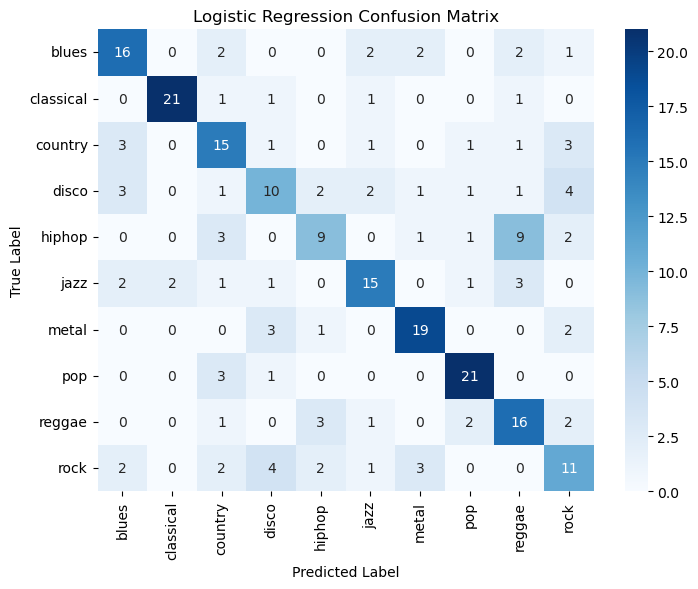

              precision    recall  f1-score   support

       blues       0.62      0.64      0.63        25
   classical       0.91      0.84      0.87        25
     country       0.52      0.60      0.56        25
       disco       0.48      0.40      0.43        25
      hiphop       0.53      0.36      0.43        25
        jazz       0.65      0.60      0.63        25
       metal       0.73      0.76      0.75        25
         pop       0.78      0.84      0.81        25
      reggae       0.48      0.64      0.55        25
        rock       0.44      0.44      0.44        25

    accuracy                           0.61       250
   macro avg       0.61      0.61      0.61       250
weighted avg       0.61      0.61      0.61       250

The best Logistic Regression model misclassified the following: 
['pop.81 misclassed as country', 'hiphop.99 misclassed as reggae', 'disco.72 misclassed as metal', 'metal.70 misclassed as hiphop', 'hiphop.29 misclassed as pop', 'metal.92 mis

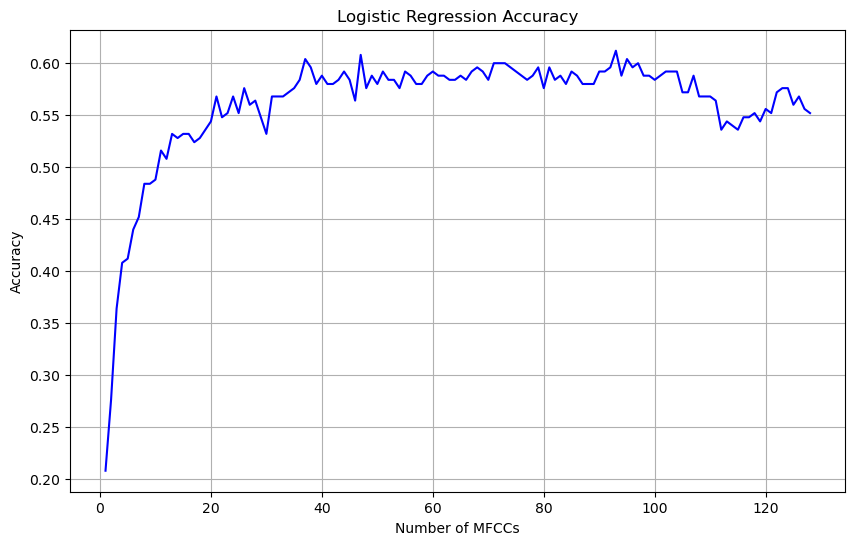

In [9]:
acc, matrix, report, lr_mismatched_files = train_logistic_regression(LR_accuracy_list.index(lr_max)+1)
lr_cm = confusion_matrix_plot(matrix, "Logistic Regression Confusion Matrix", "Blues")
lr_cm.savefig("logistic_regression_confusion_matrix.png", bbox_inches='tight')
lr_cm.show()
print(report)
print("The best Logistic Regression model misclassified the following: ")
print(lr_mismatched_files)

# Create a range for the x-axis based on the length of the accuracies list
iterations = range(1, len(LR_accuracy_list) + 1)

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(iterations, LR_accuracy_list, linestyle='-', color='b')

# Add labels, title, and grid
plt.xlabel("Number of MFCCs")
plt.ylabel("Accuracy")
plt.title("Logistic Regression Accuracy")
plt.grid(True)

plt.savefig("logistic_regression_accuracy.png", bbox_inches='tight')

# Show the plot
plt.show()

## Naive Bayes

In [10]:
def mfcc_naive_bayes(X_train, y_train):
    model = GaussianNB()
    model.fit(X_train, y_train)
    return model

def train_naive_bayes(n_mfccs=20):
    mfccs_list, labels_list = load_mfcc_data_csv(n_mfccs)
    # Convert lists to numpy arrays
    X = np.array(mfccs_list)
    y = np.array(labels_list)
    idx = np.arange(len(y))
    
    # convert the string labels into ints
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # split the data into training and testing sets
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y_encoded, idx, stratify=y_encoded, random_state=0)

    # calculate the mean and std
    mean = np.mean(X_train, axis = 0)
    std = np.std(X_train, axis=0, ddof=1)

    # standardize the data
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std

    model = mfcc_naive_bayes(X_train, y_train)
    # predict the labels for the test data
    y_pred = model.predict(X_test)

    # Evaluate the model's performance
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0)

    return accuracy, conf_matrix, class_report, return_mismatched_files(y, y_pred, y_test, idx_test)

In [11]:
NB_accuracy_list = []
for i in range(1, 129):
    acc, matrix, report, _ = train_naive_bayes(i)
    NB_accuracy_list.append(acc)
nb_max = np.max(NB_accuracy_list)

print(f"Naive Bayes produced a max accuracy of: {nb_max} with {NB_accuracy_list.index(nb_max)+1} MFCC's")

Naive Bayes produced a max accuracy of: 0.592 with 77 MFCC's


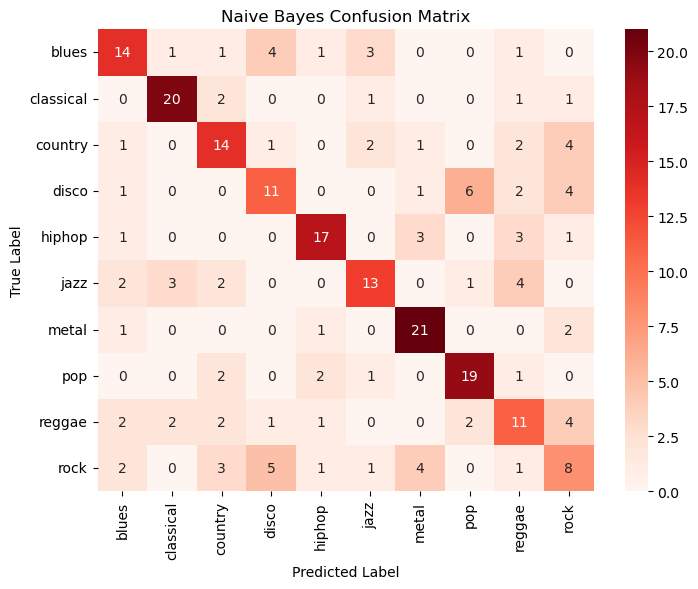

              precision    recall  f1-score   support

       blues       0.58      0.56      0.57        25
   classical       0.77      0.80      0.78        25
     country       0.54      0.56      0.55        25
       disco       0.50      0.44      0.47        25
      hiphop       0.74      0.68      0.71        25
        jazz       0.62      0.52      0.57        25
       metal       0.70      0.84      0.76        25
         pop       0.68      0.76      0.72        25
      reggae       0.42      0.44      0.43        25
        rock       0.33      0.32      0.33        25

    accuracy                           0.59       250
   macro avg       0.59      0.59      0.59       250
weighted avg       0.59      0.59      0.59       250

The best Naive Bayes model misclassified the following: 
['pop.81 misclassed as jazz', 'jazz.78 misclassed as country', 'blues.88 misclassed as jazz', 'pop.72 misclassed as hiphop', 'classical.48 misclassed as rock', 'reggae.56 misclassed as

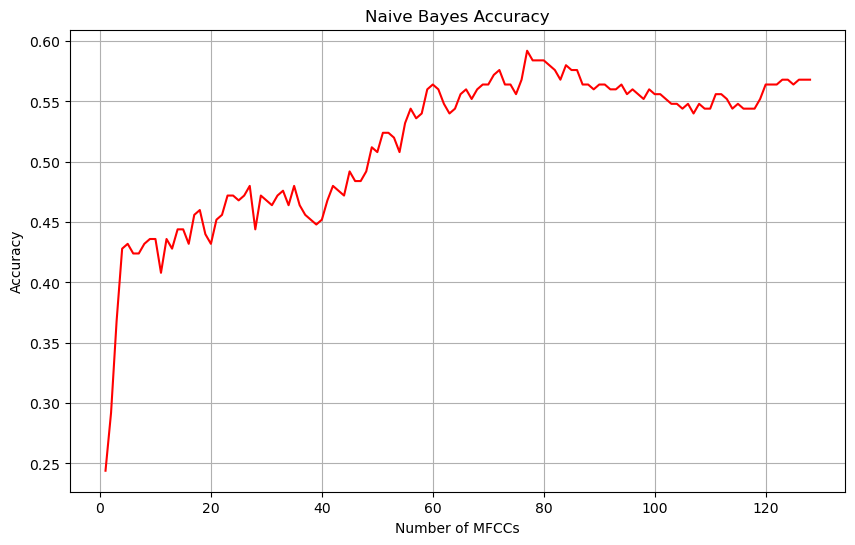

In [12]:
acc, matrix, report, nb_mismatched_files = train_naive_bayes(NB_accuracy_list.index(nb_max)+1)
nb_cm = confusion_matrix_plot(matrix, "Naive Bayes Confusion Matrix", "Reds")
nb_cm.savefig("naive_bayes_confusion_matrix.png", bbox_inches='tight')
nb_cm.show()
print(report)
print("The best Naive Bayes model misclassified the following: ")
print(nb_mismatched_files)

# Create a range for the x-axis based on the length of the accuracies list
iterations = range(1, len(NB_accuracy_list) + 1)

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(iterations, NB_accuracy_list, linestyle='-', color='r')
plt.xlabel("Number of MFCCs")
plt.ylabel("Accuracy")
plt.title("Naive Bayes Accuracy")
plt.grid(True)

plt.savefig("naive_bayes_accuracy.png", bbox_inches='tight')

# Show the plot
plt.show()

## Decision Tree

In [13]:
def mfcc_decision_tree(X_train, y_train):
    model = DecisionTreeClassifier(random_state=0)
    model.fit(X_train, y_train)
    return model

def train_decision_tree(n_mfccs=20):
    mfccs_list, labels_list = load_mfcc_data_csv(n_mfccs)
    # Convert lists to numpy arrays
    X = np.array(mfccs_list)
    y = np.array(labels_list)
    idx = np.arange(len(y))
    
    # convert the string labels into ints
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # split the data into training and testing sets
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y_encoded, idx, stratify=y_encoded, random_state=0)

    # calculate the mean and std
    mean = np.mean(X_train, axis = 0)
    std = np.std(X_train, axis=0, ddof=1)

    # standardize the data
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std

    model = mfcc_decision_tree(X_train, y_train)
    # predict the labels for the test data
    y_pred = model.predict(X_test)

    # Evaluate the model's performance
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

    return accuracy, conf_matrix, class_report, return_mismatched_files(y, y_pred, y_test, idx_test)

In [14]:
DT_accuracy_list = []
for i in range(1, 129):
    acc, matrix, report, _ = train_decision_tree(i)
    DT_accuracy_list.append(acc)
dt_max = np.max(DT_accuracy_list)

print(f"Decision Tree produced a max accuracy of: {dt_max} with {DT_accuracy_list.index(dt_max)+1} MFCC's")

Decision Tree produced a max accuracy of: 0.488 with 27 MFCC's


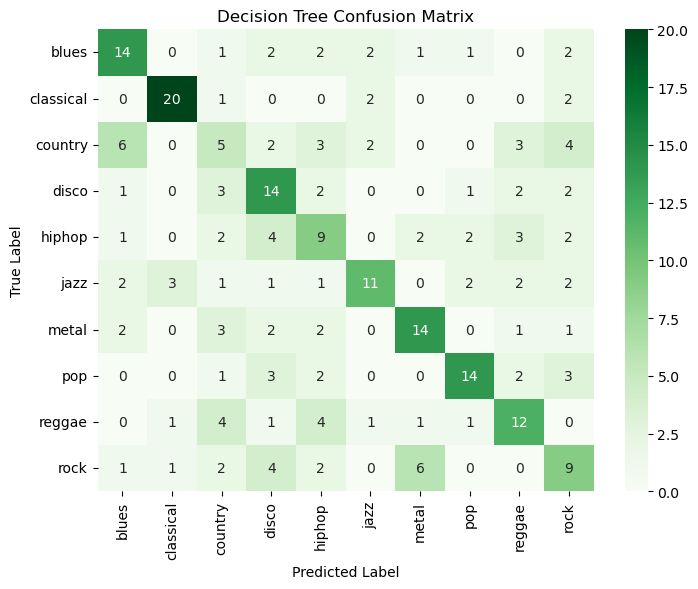

              precision    recall  f1-score   support

       blues       0.52      0.56      0.54        25
   classical       0.80      0.80      0.80        25
     country       0.22      0.20      0.21        25
       disco       0.42      0.56      0.48        25
      hiphop       0.33      0.36      0.35        25
        jazz       0.61      0.44      0.51        25
       metal       0.58      0.56      0.57        25
         pop       0.67      0.56      0.61        25
      reggae       0.48      0.48      0.48        25
        rock       0.33      0.36      0.35        25

    accuracy                           0.49       250
   macro avg       0.50      0.49      0.49       250
weighted avg       0.50      0.49      0.49       250

The best Decision Tree model misclassified the following: 
['pop.81 misclassed as rock', 'pop.72 misclassed as disco', 'jazz.45 misclassed as blues', 'hiphop.99 misclassed as blues', 'classical.48 misclassed as rock', 'reggae.56 misclassed a

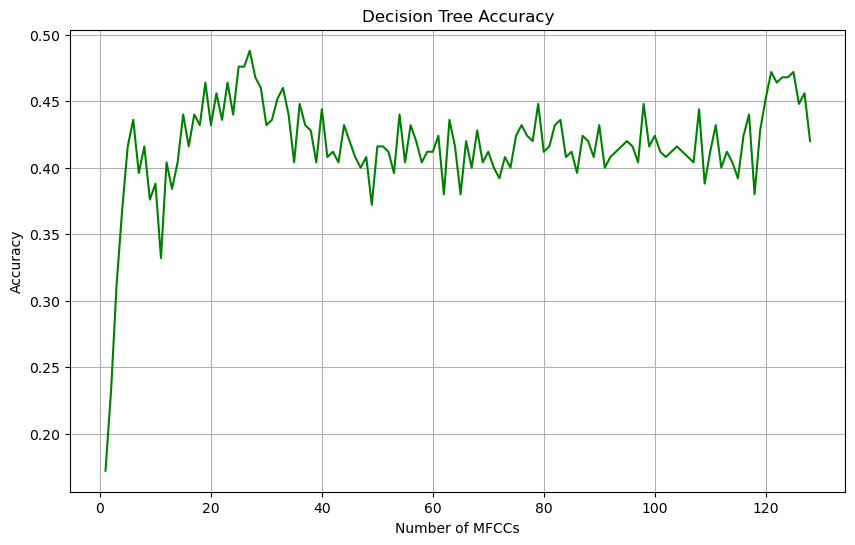

In [15]:
acc, matrix, report, dt_mismatched_files = train_decision_tree(DT_accuracy_list.index(dt_max)+1)
dt_cm = confusion_matrix_plot(matrix, "Decision Tree Confusion Matrix", "Greens")
dt_cm.savefig("decision_tree_confusion_matrix.png", bbox_inches='tight')
dt_cm.show()
print(report)
print("The best Decision Tree model misclassified the following: ")
print(dt_mismatched_files)

# Create a range for the x-axis based on the length of the accuracies list
iterations = range(1, len(DT_accuracy_list) + 1)

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(iterations, DT_accuracy_list, linestyle='-', color='g')
plt.xlabel("Number of MFCCs")
plt.ylabel("Accuracy")
plt.title("Decision Tree Accuracy")
plt.grid(True)

plt.savefig("decision_tree_accuracy.png", bbox_inches='tight')

# Show the plot
plt.show()

## K-Nearest Neighbors

In [16]:
def mfcc_knn(X_train, y_train, k=1):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    return model

def train_knn(n_mfccs=20, k=1):
    mfccs_list, labels_list = load_mfcc_data_csv(n_mfccs)
    # Convert lists to numpy arrays
    X = np.array(mfccs_list)
    y = np.array(labels_list)
    idx = np.arange(len(y))

    # convert the string labels into ints
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # split the data into training and testing sets
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y_encoded, idx, stratify=y_encoded, random_state=0)

    # calculate the mean and std
    mean = np.mean(X_train, axis = 0)
    std = np.std(X_train, axis=0, ddof=1)

    # standardize the data
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std

    model = mfcc_knn(X_train, y_train, k)
    # predict the labels for the test data
    y_pred = model.predict(X_test)

    # Evaluate the model's performance
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0)

    return accuracy, conf_matrix, class_report, return_mismatched_files(y, y_pred, y_test, idx_test)

0.648


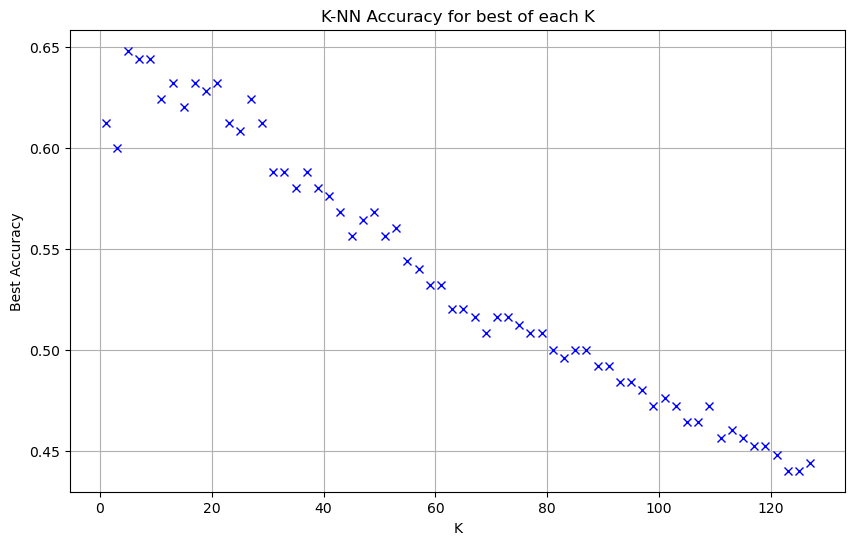

In [17]:
# Code for finding the best K to use for the ML Analysis
best_k_accuracies = []
for k in range(1, 129, 2):
    KNN_accuracy_list_test = []
    for i in range(1, 129):
        acc, matrix, report, _ = train_knn(i, k)
        KNN_accuracy_list_test.append(acc)
    max = np.max(KNN_accuracy_list_test)
    best_k_accuracies.append(max)

knn_loop_max = np.max(best_k_accuracies)
print(knn_loop_max)
# Create a range for the x-axis based on the length of the accuracies list
iterations = [(i * 2) + 1 for i in range(len(best_k_accuracies))]

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(iterations, best_k_accuracies, marker='x', linestyle='', color='b')
plt.xlabel("K")
plt.ylabel("Best Accuracy")
plt.title("K-NN Accuracy for best of each K")
plt.grid(True)

plt.savefig("knn_best_k.png", bbox_inches='tight')

# Show the plot
plt.show()

In [18]:
KNN_accuracy_list = []
for i in range(1, 129):
    acc, matrix, report, _ = train_knn(i, 5)
    KNN_accuracy_list.append(acc)
knn_max = np.max(KNN_accuracy_list)

print(f"5-NN produced a max accuracy of: {knn_max} with {KNN_accuracy_list.index(knn_max)+1} MFCC's")

5-NN produced a max accuracy of: 0.648 with 18 MFCC's


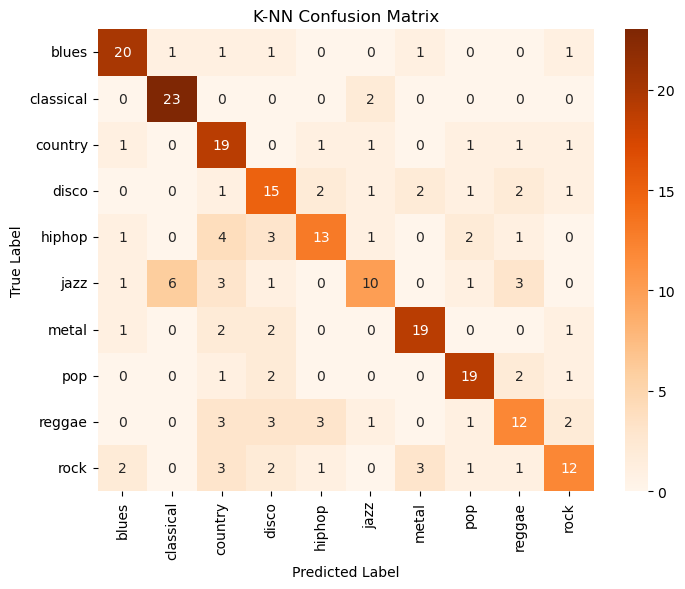

              precision    recall  f1-score   support

       blues       0.77      0.80      0.78        25
   classical       0.77      0.92      0.84        25
     country       0.51      0.76      0.61        25
       disco       0.52      0.60      0.56        25
      hiphop       0.65      0.52      0.58        25
        jazz       0.62      0.40      0.49        25
       metal       0.76      0.76      0.76        25
         pop       0.73      0.76      0.75        25
      reggae       0.55      0.48      0.51        25
        rock       0.63      0.48      0.55        25

    accuracy                           0.65       250
   macro avg       0.65      0.65      0.64       250
weighted avg       0.65      0.65      0.64       250

The best K-NN model misclassified the following: 
['pop.81 misclassed as disco', 'hiphop.99 misclassed as country', 'jazz.66 misclassed as classical', 'disco.72 misclassed as metal', 'jazz.79 misclassed as disco', 'metal.70 misclassed as cou

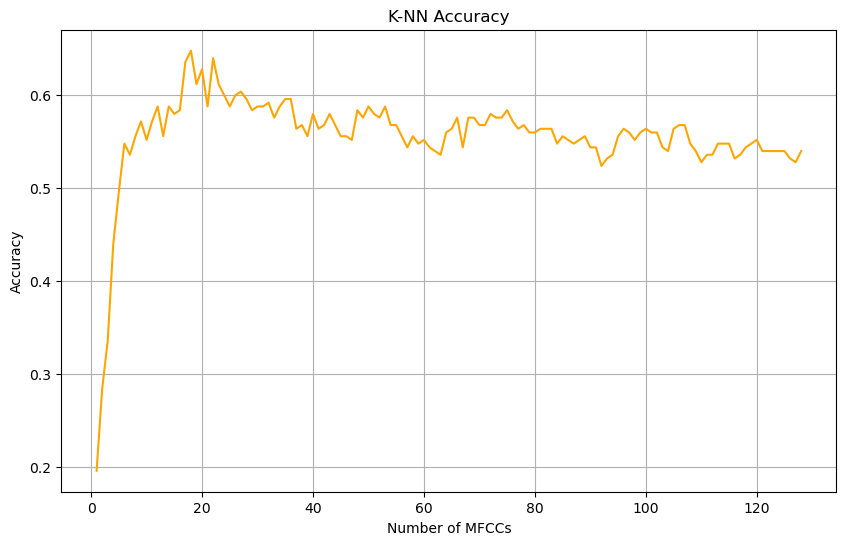

In [19]:
acc, matrix, report, knn_mismatched_files = train_knn(KNN_accuracy_list.index(knn_max)+1, 5)
knn_cm = confusion_matrix_plot(matrix, "K-NN Confusion Matrix", "Oranges")
knn_cm.savefig("knn_confusion_matrix.png", bbox_inches='tight')
knn_cm.show()
print(report)
print("The best K-NN model misclassified the following: ")
print(knn_mismatched_files)

# Create a range for the x-axis based on the length of the accuracies list
iterations = range(1, len(KNN_accuracy_list) + 1)

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(iterations, KNN_accuracy_list, linestyle='-', color='orange')
plt.xlabel("Number of MFCCs")
plt.ylabel("Accuracy")
plt.title("K-NN Accuracy")
plt.grid(True)

plt.savefig("knn_accuracy.png", bbox_inches='tight')

# Show the plot
plt.show()

## Neural Network

In [20]:
def mfcc_neural_network(X_train, y_train, n_mfccs):
    keras.config.disable_interactive_logging()
    # Build the neural network model
    model = Sequential() 

    # input = keras.Input(shape=(n_mfccs, ))
    model.add(Input((n_mfccs, )))
    model.add(Flatten()) 
    model.add(Dense(256, activation='relu')) 
    model.add(BatchNormalization()) 
    model.add(Dense(128, activation='relu')) 
    model.add(BatchNormalization()) 
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.fit(X_train, y_train, epochs = 100, batch_size=32)
    return model

def train_neural_network(n_mfccs=20):
    mfccs_list, labels_list = load_mfcc_data_csv(n_mfccs)
    # Convert lists to numpy arrays
    X = np.array(mfccs_list)
    y = np.array(labels_list)
    idx = np.arange(len(y))
    
    # convert the string labels into ints
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # split the data into training and testing sets
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y_encoded, idx, stratify=y_encoded, random_state=0)

    # calculate the mean and std
    mean = np.mean(X_train, axis = 0)
    std = np.std(X_train, axis=0, ddof=1)

    # standardize the data
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std

    model = mfcc_neural_network(X_train, y_train, n_mfccs)
    # predict the labels for the test data
    # y_pred = model.predict(X_test)
    
    test_error, test_accuracy = model.evaluate(X_test, y_test) 
    return test_error, test_accuracy

def neural_net_test(n_mfccs=20):
    mfccs_list, labels_list = load_mfcc_data_csv(n_mfccs)
    # Convert lists to numpy arrays
    X = np.array(mfccs_list)
    y = np.array(labels_list)
    idx = np.arange(len(y))
    
    # convert the string labels into ints
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # split the data into training and testing sets
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y_encoded, idx, stratify=y_encoded, random_state=0)

    # calculate the mean and std
    mean = np.mean(X_train, axis = 0)
    std = np.std(X_train, axis=0, ddof=1)

    # standardize the data
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std

    model = mfcc_neural_network(X_train, y_train, n_mfccs)
    # predict the labels for the test data
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)

    # Evaluate the model's performance
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

    return accuracy, conf_matrix, class_report, return_mismatched_files(y, y_pred, y_test, idx_test)

In [21]:
neural_net_accuracy_list = []
for i in range(1, 129):
    err, acc = train_neural_network(i)
    neural_net_accuracy_list.append(acc)
neural_net_max = np.max(neural_net_accuracy_list)

print(f"Neural Net produced a max accuracy of: {neural_net_max} with {neural_net_accuracy_list.index(neural_net_max)+1} MFCC's")

Neural Net produced a max accuracy of: 0.7039999961853027 with 27 MFCC's


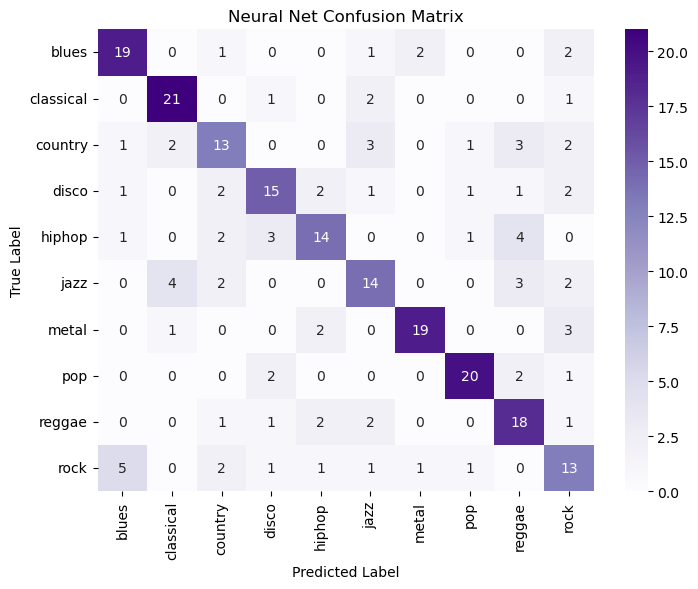

              precision    recall  f1-score   support

       blues       0.70      0.76      0.73        25
   classical       0.75      0.84      0.79        25
     country       0.57      0.52      0.54        25
       disco       0.65      0.60      0.63        25
      hiphop       0.67      0.56      0.61        25
        jazz       0.58      0.56      0.57        25
       metal       0.86      0.76      0.81        25
         pop       0.83      0.80      0.82        25
      reggae       0.58      0.72      0.64        25
        rock       0.48      0.52      0.50        25

    accuracy                           0.66       250
   macro avg       0.67      0.66      0.66       250
weighted avg       0.67      0.66      0.66       250

The best Neural Net model misclassified the following: 
['pop.81 misclassed as reggae', 'pop.72 misclassed as rock', 'hiphop.99 misclassed as blues', 'classical.34 misclassed as jazz', 'jazz.66 misclassed as country', 'disco.72 misclassed as

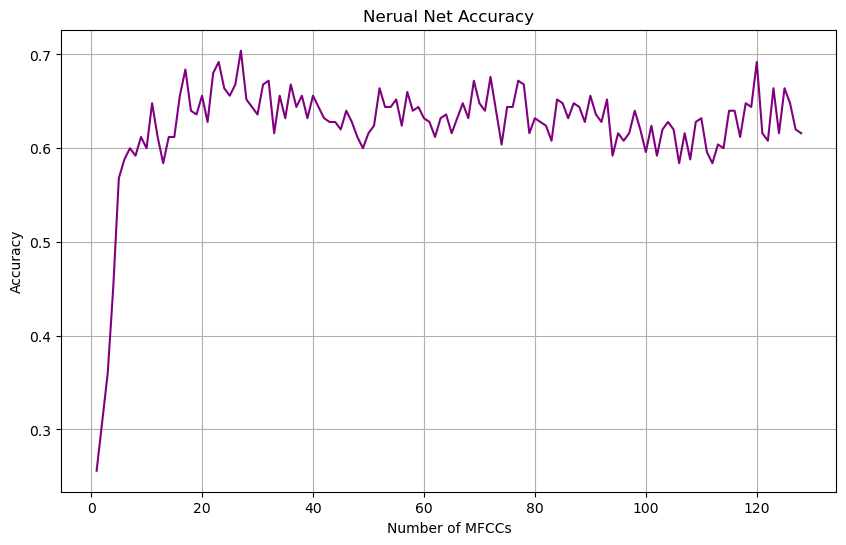

In [22]:
acc, matrix, report, nn_mismatched_files = neural_net_test(neural_net_accuracy_list.index(neural_net_max)+1)
nn_cm = confusion_matrix_plot(matrix, "Neural Net Confusion Matrix", "Purples")
nn_cm.savefig("neural_net_confusion_matrix.png", bbox_inches='tight')
nn_cm.show()
print(report)
print("The best Neural Net model misclassified the following: ")
print(nn_mismatched_files)

# Create a range for the x-axis based on the length of the accuracies list
iterations = range(1, len(neural_net_accuracy_list) + 1)

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(iterations, neural_net_accuracy_list, linestyle='-', color='purple')
plt.xlabel("Number of MFCCs")
plt.ylabel("Accuracy")
plt.title("Nerual Net Accuracy")
plt.grid(True)

# Show the plot
plt.savefig("neural_net_accuracy.png", bbox_inches='tight')
plt.show()

-- --
#### Post Training Analysis

There are 2 MFCCs where a classical model outperforms the Nerual Net


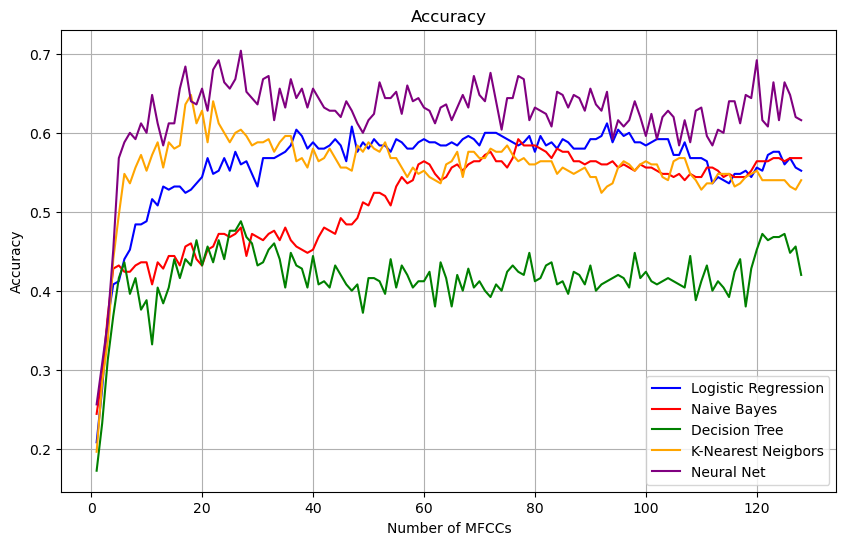

In [30]:
# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(iterations, LR_accuracy_list, linestyle='-', color='b', label="Logistic Regression")
plt.plot(iterations, NB_accuracy_list, linestyle='-', color='r', label="Naive Bayes")
plt.plot(iterations, DT_accuracy_list, linestyle='-', color='g', label="Decision Tree")
plt.plot(iterations, KNN_accuracy_list, linestyle='-', color='orange', label="K-Nearest Neigbors")
plt.plot(iterations, neural_net_accuracy_list, linestyle='-', color='purple', label="Neural Net")
plt.xlabel("Number of MFCCs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid(True)
plt.legend()

plt.savefig("comgbined_accuracy.png", bbox_inches='tight')

comparison_results = [
    (a1 > a5, a2 > a5, a3 > a5, a4 > a5)
    for a1, a2, a3, a4, a5 in zip(LR_accuracy_list, NB_accuracy_list, DT_accuracy_list, KNN_accuracy_list, neural_net_accuracy_list)
]

count = sum(any(comparison) for comparison in comparison_results)

print(f"There are {count} MFCCs where a classical model outperforms the Nerual Net")

# Show the plot
plt.show()

In [24]:
mismatched_counter = {}
for list in [lr_mismatched_files, nb_mismatched_files, dt_mismatched_files, knn_mismatched_files, nn_mismatched_files]:
    for misclassedStr in list:
        file = misclassedStr.split(" misclassed as")[0]
        if file in mismatched_counter:
            mismatched_counter[file] = mismatched_counter[file] + 1
        else:
            mismatched_counter[file] = 1

filtered_dict = mismatched_counter

df = pd.DataFrame(mismatched_counter.items(), columns=['File Name', 'Mismatched Count']).sort_values(by='Mismatched Count', ascending=False)
pd.set_option('display.max_rows', None)
print("The following displays all of the misclassified song.  If they have a 5, they were misclassified by all of the models.")
display(df)

The following displays all of the misclassified song.  If they have a 5, they were misclassified by all of the models.


,File Name,Mismatched Count
0,pop.81,5
56,pop.10,5
64,disco.19,5
53,reggae.94,5
27,reggae.52,5
28,pop.12,5
78,rock.63,5
81,disco.0,5
87,blues.81,5
30,metal.81,5


-- --